In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, ToPILImage, Resize, Compose
from torch import nn
from torch.nn import functional as F
from torchvision.models import vgg11, vgg16
from tensorboardX import SummaryWriter
import torchvision.utils as vutils

In [2]:
import os
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from PIL import Image as pilimage

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from IPython.display import clear_output 

In [3]:
class Person:
    def __init__(self, name):
        self.name = name
        self.new = []
        self.old = []
        self.resize = Resize((224, 224))

    def add(self, age, num):
        pic = self.resize(
                  pilimage.open('../data/CACD2000/'+ str(age) + '_' + self.name + '_' + str(num) + '.jpg') #TODO format
              )
        if int(age) > 30:
            self.old.append(pic)
        else:
            self.new.append(pic)
            
    def get_old(self):
        return random.sample(self.old, 1)[0]
    def get_new(self):
        return random.sample(self.new, 1)[0]

In [ ]:
import pickle

persons = {}

for pack in tqdm(os.listdir('../data/persons/')):
    with open('../data/persons/' + pack, 'rb') as f:
        dump = pickle.load(f)
        persons.update(dump)

In [ ]:
identity_model = torch.load('../data/models/identity_model.pth')
identity_model.fc = nn.Sequential().cuda()
identity_model.eval()
pass

In [ ]:
for param in identity_model.parameters():
    param.requires_grad = False


In [ ]:
age_model = torch.load('../data/models/age_model.pth')
age_model.eval()
pass

In [ ]:
class AgeDataset(Dataset):
    def __init__(self, persons):
        self.persons = persons
        self.keys = list(persons.keys())
        
    def __len__(self):
        return len(self.persons) # 163446
    
    def __getitem__(self, ind):
        flag = 1
        while flag:
            pers = random.sample(self.keys, 1)[0]
            pers = persons[pers]
            try:
                new = pers.get_new()
                old = pers.get_old()
            except ValueError:
                continue
            flag = 0
        return ToTensor()(new), ToTensor()(old)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 9, 1, 4),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
#             nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
#             nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.ress = nn.ModuleList([nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
#             nn.BatchNorm2d(128),
            nn.ReLU(),
        ) for _ in range(4)])
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1),
#             nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 12, 1, 4),
        )
    
    def forward(self, x): # херня с резблоками
        x = self.conv(x)
        for conv in self.ress:
            x = conv(x) + x
        return self.upconv(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = age_model.features
        self.path1 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path2 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path4 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        for param in self.features:
            param.requires_grad = False
        self.clf = nn.Linear(12*3, 1)
        
    def forward(self, x):
        conv_num = 0
        flag = 0
        results = []
        for module in self.features.modules():
            if flag == 0:
                flag += 1
                continue
            if isinstance(module, nn.Conv2d):
                conv_num+=1
                if conv_num == 2:
                    results.append(self.path4(x))
                if conv_num == 4:
                    results.append(self.path3(x))
                if conv_num == 7:
                    results.append(self.path2(x))
                if conv_num == 10:
                    results.append(self.path1(x))
            x = module(x)
        results = torch.cat(results, dim=1)
        return results
        # return self.clf(results.view(results.size(0), -1)).view(-1)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
generator = Generator().apply(weights_init).cuda()
discriminator = Discriminator().apply(weights_init).cuda()

total_shape = 224*224*3

ageset = AgeDataset(persons)
ageloader = DataLoader(ageset, batch_size=4)

generator_optim = torch.optim.Adam(generator.parameters(), 1e-4)#, weight_decay=0.5)
discriminator_optim = torch.optim.Adam(discriminator.parameters())#, 1e-4, weight_decay=1)
writer = SummaryWriter('../logs/gan/default.v4_тщ')

In [13]:
def get_grad_norm(parameters, norm_type=2):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1. / norm_type)
    return total_norm

In [14]:
def adjust_w_decay(optimizer):
    return 
#     state_dict = optimizer.state_dict()
#     for param_group in state_dict['param_groups']:
#         param_group['weight_decay'] = param_group['weight_decay'] * 0.5
#     optimizer.load_state_dict(state_dict)

In [16]:
for epoch in tqdm(range(78, 300), desc='epoch'):
    gen_losses = []
    disc_losses = []
    
    adjust_w_decay(generator_optim)
    adjust_w_decay(discriminator_optim)
    
    generator.train()
    discriminator.train()
    for iter_ind, (new, old) in enumerate(tqdm(ageloader, leave=False, desc='train')):
        new, old = new.cuda(), old.cuda()
        
        if iter_ind % 2 == 0:
            generator_optim.zero_grad()
#             old_gen = generator(new)  # mb change
            disc_ans = discriminator(generator(new))
            identity_loss = 0.05 * torch.mean(torch.pow(F.pairwise_distance(identity_model(new), identity_model(generator(new))), 2))
            writer.add_scalar('generator/identity_loss', identity_loss.item(), epoch*len(ageloader)+iter_ind)
            gan_loss = 750 * torch.mean(torch.pow(discriminator(generator(new)) - 1, 2))
            writer.add_scalar('generator/gan_loss', gan_loss.item(), epoch*len(ageloader)+iter_ind)
            generator_loss = identity_loss + gan_loss
            if iter_ind % 4 == 0:
                objective_loss = 1.0 * torch.mean(torch.pow(torch.norm(generator(new) - new, dim=1), 2) / total_shape)
                generator_loss += objective_loss
                writer.add_scalar('generator/objective_loss', objective_loss.item(), epoch*len(ageloader)+iter_ind)
            writer.add_scalar('generator/generator_loss', generator_loss.item(), epoch*len(ageloader)+iter_ind)
            generator_loss.backward()
            writer.add_scalar('generator/grad_norm', get_grad_norm(generator.parameters()), epoch*len(ageloader)+iter_ind)
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)
            generator_optim.step()
            generator_optim.zero_grad()
            gen_losses.append(generator_loss.item())

        
        discriminator_optim.zero_grad()
        disc_loss_1 = torch.mean(torch.pow(discriminator(old) - 1, 2))
        disc_loss_2 = torch.mean(torch.pow(discriminator(generator(new).detach()), 2) + \
                               torch.pow(discriminator(new), 2))
        disc_loss = disc_loss_1 * 0.5 + disc_loss_2 * 0.5
        writer.add_scalar('discriminator/old-1', disc_loss_1.item(), epoch*len(ageloader)+iter_ind)
        writer.add_scalar('discriminator/generated-vs-new', disc_loss_2.item(), epoch*len(ageloader)+iter_ind)
        writer.add_scalar('discriminator/discriminator_loss', disc_loss.item(), epoch*len(ageloader)+iter_ind)
        disc_loss.backward()
        writer.add_scalar('discriminator/grad_norm', get_grad_norm(discriminator.parameters()), epoch*len(ageloader)+iter_ind)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        discriminator_optim.step()
        discriminator_optim.zero_grad()
        disc_losses.append(disc_loss.item())
        
    ageloader_eval = DataLoader(ageset, batch_size=1, shuffle=True)
    generator.eval()
    discriminator.eval()
    eval_count = 0
    for i, (new, old) in enumerate(ageloader_eval):
        writer.add_image('example_{}'.format(i),
                         vutils.make_grid(torch.stack([new[0], old[0], 
                                                       torch.clamp(generator(new.cuda()), 0, 1)[0].cpu()]), nrow=3),
                         epoch)
        eval_count += 1
        if eval_count == 5:
            break

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
# torch.save(generator, '../data/models/generator_nobn.pth')
# torch.save(discriminator, '../data/models/discriminator_nobn.pth')

/home/mrartemev/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mrartemev/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
torch.save(generator, '../data/models/generator_temp.pth')
torch.save(discriminator, '../data/models/discriminator_temp.pth')

In [16]:
# torch.save(generator, '../data/models/generator_300.pth')
# torch.save(discriminator, '../data/models/discriminator_300.pth')

/home/mrartemev/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mrartemev/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
1

1

In [17]:
ageloader_eval = DataLoader(ageset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


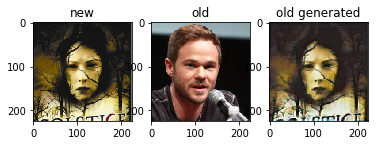

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


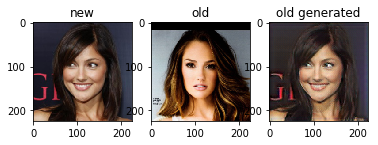

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


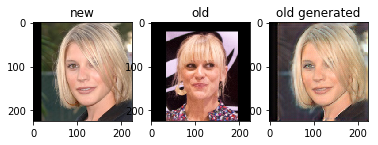

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


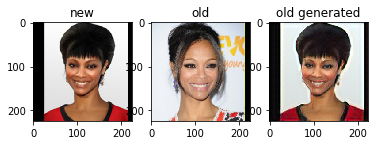

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


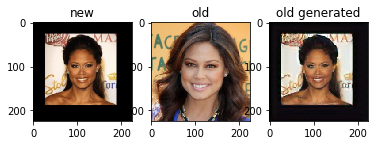

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


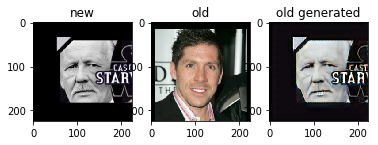

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


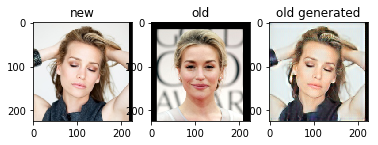

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


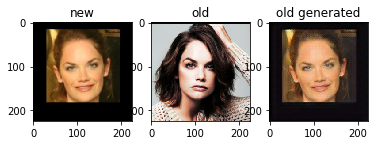

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


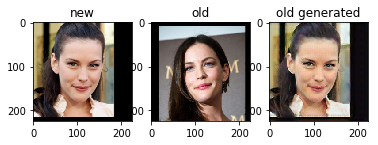

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


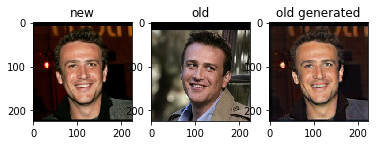

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


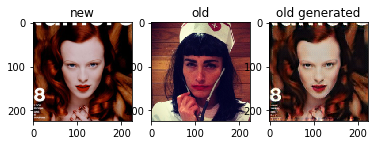

In [19]:
generator.eval()
discriminator.eval()
i = 0
for new, old in tqdm(ageloader_eval):
    i+=1
    new = new.cuda()
    old_gen = generator(new)
    plt.subplot(1,3,1)
    plt.title('new')
    plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,2)
    plt.title('old')
    plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,3)
    plt.title('old generated')
    plt.imshow(old_gen.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.show()
    if i > 10:
        break

In [1]:
11

11